<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionDetectionAlertes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection d'alertes par réseaux de neurones

Dans cet exercice, le but est de créer un système très basique de détection de messages douteux  par Réseaux de Neurones en se basant uniquement sur des mots clés trouvés dans les sujets de mails.

Une version plus évoluée étudierait aussi le texte transformé en sac de mots.


---
*L’observation du contenu des communications par les gouvernements dans un but de sécurité permettrait de détecter les mails potentiellement dangereux et de lever des alertes.
Cependant la masse d’information échangée est trop importante pour garantir une bonne analyse.
Des réseaux de neurones peuvent être utilisés pour guider la détection de problèmes potentiels.*

*Il s’agit donc ici de définir un réseau de neurones et de lui faire apprendre à détecter des textes à risque.*

---

Les exemples d’apprentissage seront constitués :
- d’une série de valeurs indiquant si oui ou non un terme est présent dans le texte analysé,
- de la réponse attendue (dans la ligne danger)

Pour chaque texte, des mots-clés sont détectés, et le danger potentiel du texte est indiqué. Voici les exemples d’apprentissage :
 - 'bombe', 'feu' => danger
 - 'bombe', 'patisserie' => _
 - 'bombe', 'acide' => danger
 - 'bombe', 'canon' => danger
 - 'fille', 'canon' => _
 - 'mec', 'canon' => _
 - 'patisserie', 'acide' => _
 - 'canon', 'balle' => danger
 - 'balle', 'tennis' => _
 - 'fille', 'acide' => danger
 
 Il faut transformer cela en un ensembles de vecteurs d'entrées et de sorties.

| bombe | feu | patisserie | fille | canon | mec | acide | balle | tennis | *danger* |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| 1., | 1., | 0., | 0., | 0., | 0., | 0., | 0., | 0. |  1  |
| 1., | 0., | 0., | 0., | 0., | 0., | 1., | 0., | 0. |  1  |
| 1., | 0., | 0., | 0., | 1., | 0., | 0., | 0., | 0. |  1  |
| 0., | 0., | 0., | 0., | 1., | 0., | 0., | 1., | 0. |  1  |
| 0., | 0., | 0., | 1., | 0., | 0., | 1., | 0., | 0. |  1  |
| 1., | 0., | 1., | 0., | 0., | 0., | 0., | 0., | 0. |  0  |
| 0., | 0., | 0., | 1., | 1., | 0., | 0., | 0., | 0. |  0  |
| 0., | 0., | 0., | 0., | 1., | 1., | 0., | 0., | 0. |  0  |
| 0., | 0., | 1., | 0., | 0., | 0., | 1., | 0., | 0. |  0  |
| 0., | 0., | 0., | 0., | 0., | 0., | 0., | 1., | 1. |  0  |



---
## Importer les librairies

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
#pour les graphiques
import matplotlib.pyplot as plt
#SI bug plus loin lors du dessin des graphiques, ajouter ces 2 lignes
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

### Définir les entrées et sorties attendues

Les entrées correspondent à la présence des mots clés par dans les textes.
Ici, les entrées d'apprentissage sont consituées de 70% de l'exemple présenté (donc 7 lignes de  9 valeurs 0,1). Les sorties d'apprentissage correspondent au fait que chaque entrée soit un message dangereux ou non.

Les entrées et sorties de validations sont donc constitués des 30% restants


In [2]:
#transformer les données en entrées et sorties
# attention, il vaut mieux rester entre 0 & 1, surtout pour la sortie !

tableau = np.array([
[1.,1.,0.,0.,0.,0.,0.,0.,0.,1], 
[1.,0.,0.,0.,0.,0.,1.,0.,0.,1], 
[1.,0.,0.,0.,1.,0.,0.,0.,0.,1], 
[0.,0.,0.,0.,1.,0.,0.,1.,0.,1], 
[0.,0.,0.,1.,0.,0.,1.,0.,0.,1], 
[1.,0.,1.,0.,0.,0.,0.,0.,0.,0], 
[0.,0.,0.,1.,1.,0.,0.,0.,0.,0], 
[0.,0.,0.,0.,1.,1.,0.,0.,0.,0], 
[0.,0.,1.,0.,0.,0.,1.,0.,0.,0], 
[0.,0.,0.,0.,0.,0.,0.,1.,1.,0]], float)

keywords = ("bombe", "feu", "patisserie", "fille", "canon", "mec", "acide", "balle", "tennis")    
nb_lignes = tableau.shape[0]
nb_val = len(keywords)


In [4]:
#on prend un pourcentage de lignes pour apprendre, le reste pour valider
#on mélange les lignes pour pouvoir avoir des exemples d'apprentissage
# et de validation homogènes (au cas où les exemples auraient été saisis dans un ordre précis)
# mais le mieux est de mieux choisir ces exemples qui ont un impact important dans la qualité de l'apprentissage
np.random.shuffle(tableau)

#on décide que 60% des lignes sont des lignes d'apprentissage
nb_lignes_app = nb_lignes * 60 // 100
nb_lignes_val = nb_lignes - nb_lignes_app

# les premieres colonnes sont les entrees 
# la derniere colonne est la sortie

#on remplit les entrees et sorties d'apprentissage
entrees_app = tableau[0:nb_lignes_app, 0:nb_val]
sorties_app = tableau[0:nb_lignes_app, nb_val:nb_val+1]

#on remplit les entrees et sorties de validation
entrees_val = tableau[nb_lignes_app:nb_lignes, 0:nb_val]
sorties_val = tableau[nb_lignes_app:nb_lignes, nb_val:nb_val+1]

---

### Choisir le modèle de réseau
- ici les couches sont séquentielles

In [15]:
model = Sequential()

---

### Définir l'architecture du réseau
Choisissez la struture du réseau, le nb de couches cachées, etc.
- une première couche composée de 
  - autant de neurones en entrée que de mots clés, plus le neurone BIAS (ou non)
  - x neurones en sortie 
- une dernière couche composée de
  - y neurones en entrée (ceux de la couche précédente) et 
  - de 1 neurone en sortie (Spam ou non)


In [14]:
entrees_app.shape

(6, 9)

In [16]:
#une premiere couche constituée d'autant de neurones en entrée que de mots clés, 6 en sortie...
model.add(Dense(5, use_bias=True, input_shape=(nb_val,), activation='sigmoid'))

#une couche intermédiaire, 3 neurones en sortie et forcement 6 en entrees...
#model.add(Dense(3, use_bias=True, activation='sigmoid'))

#une derniere couche constituée de 1 neurone en sortie, 
# nb neurones de la couche précédente en entrée et activation sigmoide
model.add(Dense(1, activation='sigmoid'))

---

### Compiler le  réseau
- ici, on précise que l'algo de correction d'erreur est *'adam'*, et que l'erreur calculée est la moyenne des valeurs absolues des erreurs commises. On indique également que l'on veut voir apparaître en plus la précision de l'apprentissage (accuracy).

(vous pouvez chosir un autre optimizer et un autre calcul de loss)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

---

### Entraîner le réseau 
- ici on  le fait  'parler' (verbose=2) si le nb de cycles d'apprentissage (epochs) est court


In [18]:
tests = model.fit(entrees_app, sorties_app, 
                    validation_data=(entrees_val, sorties_val),
                    epochs=300, verbose=2)

Epoch 1/300
1/1 - 1s - 567ms/step - accuracy: 0.8333 - loss: 0.6844 - val_accuracy: 1.0000 - val_loss: 0.6558
Epoch 2/300
1/1 - 0s - 64ms/step - accuracy: 0.8333 - loss: 0.6840 - val_accuracy: 1.0000 - val_loss: 0.6559
Epoch 3/300
1/1 - 0s - 60ms/step - accuracy: 0.8333 - loss: 0.6837 - val_accuracy: 1.0000 - val_loss: 0.6559
Epoch 4/300
1/1 - 0s - 63ms/step - accuracy: 0.8333 - loss: 0.6833 - val_accuracy: 1.0000 - val_loss: 0.6559
Epoch 5/300
1/1 - 0s - 73ms/step - accuracy: 0.8333 - loss: 0.6829 - val_accuracy: 1.0000 - val_loss: 0.6559
Epoch 6/300
1/1 - 0s - 64ms/step - accuracy: 0.8333 - loss: 0.6826 - val_accuracy: 1.0000 - val_loss: 0.6560
Epoch 7/300
1/1 - 0s - 65ms/step - accuracy: 0.8333 - loss: 0.6822 - val_accuracy: 1.0000 - val_loss: 0.6560
Epoch 8/300
1/1 - 0s - 61ms/step - accuracy: 0.8333 - loss: 0.6819 - val_accuracy: 1.0000 - val_loss: 0.6560
Epoch 9/300
1/1 - 0s - 63ms/step - accuracy: 0.8333 - loss: 0.6815 - val_accuracy: 1.0000 - val_loss: 0.6561
Epoch 10/300
1/1 -

---

## Dessiner l'évolution de l'erreur et de la pertinence


In [19]:
history_dict = tests.history
eval_tests = list(history_dict.keys())
print("les ensembles de valeurs récupérées lors des tests sont ")
print(eval_tests)
print("-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]")


les ensembles de valeurs récupérées lors des tests sont 
['accuracy', 'loss', 'val_accuracy', 'val_loss']
-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]


#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

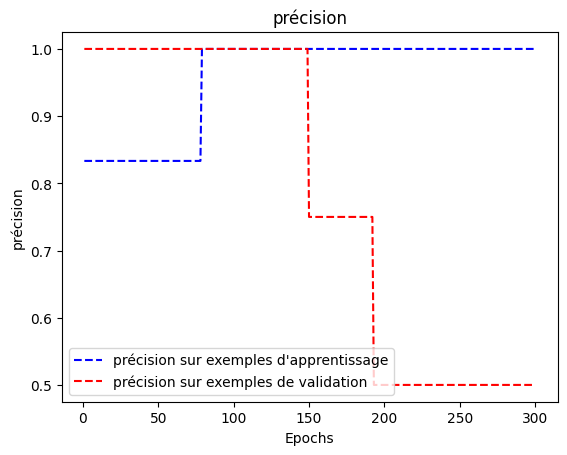

In [ ]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b--', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r--', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

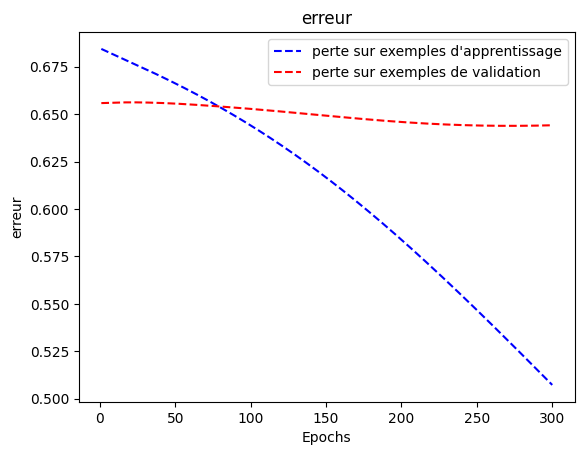

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b--', label='perte sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r--', label='perte sur exemples de validation')
plt.title('erreur')
plt.xlabel('Epochs')
plt.ylabel('erreur')
plt.legend()

plt.show()

---
## Utilisation du réseau
Quelle est la probabilité que les textes contenant les mots :
1. bombe et feu
2. mec patisserie feu

soient des textes suspects ?

In [27]:
def build_input(mots):
    inputs = np.zeros(len(keywords))
    i = 0
    for mot in mots:
        inputs[tuple.index(keywords, mot)] = 1
    return inputs

input_test = build_input(('feu', 'balle'))
entreesTests = np.array([input_test], float)

predictions = model.predict(entreesTests)
print(predictions)

input_test = build_input(('mec', 'patisserie', 'feu'))
entreesTests = np.array([input_test], float)

predictions = model.predict(entreesTests)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.4955779]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.34512383]]
